# (i) **Сопоставление кривых X-ray IT92 и Coppens для нейтрального атома**

In [ ]:
#@title 👨‍🍳 Анализируем кривые X-ray 🥧
def analyze_f_xray(name_atom, save_dir=None, x_max=2.5, show_stats=True,
                   return_stats=False):
  """
  Анализ и визуализация рентгеновских атомных форм-факторов по данным Coppens и IT92.

  Функция строит сравнение рентгеновских атомных форм-факторов из базы Coppens и
  справочника IT92, вычисляет их разности Δf = f_IT92 − f_Coppens, оценивает статистику
  по диапазонам sinθ/λ и, при необходимости, сохраняет график в HTML-файл.

  Параметры
  ----------
  name_atom : str                     ← Название атома (например, "F", "Ca", "O").
  save_dir : str, optional            ← Каталог для сохранения графика:
                                            - None  — только отображение графика;
                                            - "colab" — сохранить в /content/Xray_curves;
                                            - "gdrive" — сохранить в /content/drive/MyDrive/Xray_curves.
  x_max : float, default=2.5           ← Максимальное значение по оси X (sinθ/λ).
  show_stats : bool, default=True      ← Показывать на графике таблицу со статистикой по диапазонам.
  return_stats : bool, default=False   ← Если True, возвращает словарь со статистикой (вместо показа графика).

  Возвращает
  ----------
  dict, optional     ← Если return_stats=True:
                        {"atom":   str,
                         "Z":     int,
                         "stats": [{"range": "0.0-0.1", "MAE": ..., "max_abs": ..., "max_rel": ...},
                                   {"range": ...                                                  },  ]}

  Примеры
  --------
  >>> analyze_f_xray("F")                     # Только показать график
  >>> analyze_f_xray("F", save_dir="gdrive")  # Сохранить в Google Drive (в /content/drive/MyDrive/Xray_curves)
  >>> analyze_f_xray("F", save_dir='colab')   # Сохранить в Colab        (в /content/Xray_curves)
  >>> analyze_f_xray("F", return_stats=True)  # Вернуть статистику без графика
  """
  import gemmi, os, re
  atom_test = Atom(name=name_atom)
  curves    = atom_test.info['curves']

  ## График с кривыми рассеяния neutral atom, core, valence shells (всё это из Coppens), и кривой из it4322 для neutral atom
  fig  = atom_test.view(wave='x', return_fig=True) ## Основной график с view(wave='x')

  ## Кривая рассеяния электронов из IT 92 (берем отдельно)
  atom   = re.sub("[^A-Za-z]", "", atom_test.name)
  Z      = PARAM["elements"][atom]['Z']  # атомный номер
  coef_x = gemmi.Element(atom).it92        ## Кривая рентгеновского рассеяния из IT 92
  y_it   = np.array([coef_x.calculate_sf(stol2=stl0*stl0) for stl0 in curves['neutral atom']['x']])

  # --- Данные ---
  x      = curves['neutral atom']['x']
  y_copp = curves['neutral atom']['y']
  diff   = y_it - y_copp                     # Разность Coppens - IT92
  tr_diff = go.Scatter(x=x, y=diff, name='Δ Coppens - IT92', line=dict(color='red', dash='dot'), yaxis='y2')  # вторичная ось для разности
  fig.add_trace(tr_diff)

  # --- Выводим статистику по диапазонам (опционально) ---
  stats_data = []
  if show_stats or return_stats:
      ranges = [(0.0,0.1),(0.1,0.5),(0.5,1.0),(1.0,2.0),(2.0,6.0)]              ## Разделим на диапазоны
      rows = []
      for r in ranges:
        mask = (x >= r[0]) & (x < r[1])
        n = np.sum(mask)
        if n > 0:
          y_diff_r = diff[mask]
          MAE = np.mean(np.abs(y_diff_r))
          RMSE = np.sqrt(np.mean(y_diff_r**2))
          max_abs = np.max(np.abs(y_diff_r))
          max_rel = np.max(np.abs(y_diff_r / np.where(y_copp[mask]!=0,y_copp[mask],1)))
          rows.append([f"{r[0]:.1f}-{r[1]:.1f}", MAE, max_abs, max_rel])      ## Убираем n и RMSE
          stats_data.append({"range": f"{r[0]:.1f}-{r[1]:.1f}",
                             "MAE": MAE, "max_abs": max_abs, "max_rel": max_rel})
      # Формируем псевдотаблицу
      header = f"{'Range':<8} {'⟨|Δf|⟩':<10} {'max|Δf|':<10} {'max|Δf|/f':<12}"
      lines  = [header]
      for row in rows: lines.append(f"{row[0]:<8} {row[1]:<10.3f} {row[2]:<10.3f} {row[3]:<12.3f}")

      stats_table = "<br>".join(lines)
      # Добавим аннотацию на график
      fig.add_annotation(x=0.98, y=0.98, xref='paper', yref='paper',
                       text=f"<span style='font-family:Courier New; font-size:12px'>{stats_table}</span>",
                       showarrow=False, align='left',
                       bordercolor='black', borderwidth=1, borderpad=4, bgcolor='rgba(255,255,255,0.7)')
      # --- Вторая аннотация: пояснение про f ---
      fig.add_annotation(x=0.98, y=0.81, xref='paper', yref='paper',
          text=("<span style='font-family:Times New Roman; font-size:12px'>"
              "<i>f</i> — атомный рентгеновский форм-фактор;   "
              "Δ<i>f</i> = <i>f</i><sub>IT92</sub> − <i>f</i><sub>Coppens</sub>"
              "</span>"), showarrow=False, align='left', bordercolor='rgba(0,0,0,0)', bgcolor='rgba(255,255,255,0.5)')
  # --- Легенда ---
  fig.update_layout(legend=dict(x=0.98, y=0.77, xanchor="right", yanchor="top",
                                bgcolor="rgba(255,255,255,0.6)", bordercolor="black", borderwidth=1))

  # --- Добавляем IT92 coefficients ---
  coef_text = ("<b>IT92 coefficients:</b><br>"
               "<span style='font-family:Courier New; font-size:12px'>"
               f"a: {coef_x.a[0]:8.4f} {coef_x.a[1]:8.4f} {coef_x.a[2]:8.4f} {coef_x.a[3]:8.4f}<br>"
               f"b: {coef_x.b[0]:8.4f} {coef_x.b[1]:8.4f} {coef_x.b[2]:8.4f} {coef_x.b[3]:8.4f}<br>"
               f"c: {coef_x.c:8.4f}"
               "</span>")
  # --- Добавляем как аннотацию ниже легенды ---
  fig.add_annotation(x=0.98, y=0.43, xref='paper', yref='paper',
    text=f"<span style='font-family:Times New Roman; font-size:12px'>{coef_text}</span>",
    showarrow=False, align='left', bordercolor='rgba(0,0,0,0)',
    bgcolor='rgba(255,255,255,0.3)', borderpad=4, opacity=0.9,
    font=dict(family="Times New Roman"))

  # --- Настройки X, Y ---
  fig.update_xaxes(range=[0, x_max])
  d_abs = max(abs(diff.min()), abs(diff.max()))
  diff_range = [-d_abs, d_abs]
  fig.update_layout(yaxis2=dict(title="Δf = f<sub>IT92</sub> − f<sub>Coppens</sub>", titlefont=dict(color="red"), tickfont=dict(color="red"),
                     overlaying="y", side="right", showgrid=False, range=diff_range, zeroline=True,))
  fig.add_trace(go.Scatter(x=[np.min(x), x_max], y=[0, 0], yaxis="y2", mode="lines",
                           line=dict(color="red", width=1), opacity=0.4, name="", showlegend=False))
  fig.add_trace(go.Scatter(x=[x_max, x_max], y=[diff_range[0], diff_range[1]], yaxis="y2", mode="lines",
                           line=dict(color="red", width=1.5), opacity=0.4, showlegend=False))

  # ---Сохранение / График ---
  if save_dir is not None:
    if save_dir   == "gdrive":   save_dir_full = "/content/drive/MyDrive/Xray_curves"
    elif save_dir == "colab":    save_dir_full = "/content/Xray_curves"
  #if save_dir:
    os.makedirs(save_dir_full, exist_ok=True)
    filename = f"{Z}_{atom}.html"
    path     = os.path.join(save_dir_full, filename)
    fig.write_html(path)
    print(f"✅ Saved to: {path}")
  elif (save_dir is None) and (return_stats==False):
    fig.show()
  # --- Возврат словаря с инфо об атоме и статистикой ---
  if return_stats:
    return {"atom": atom,  "Z": Z,  "stats": stats_data}

## Пример
#for atom_name in list1:
#    analyze_f_xray(atom_name, save_dir='gdrive')

In [ ]:
## Пример результата анализа кривых для одного атома

atom_name = 'Ta'
analyze_f_xray(atom_name)

[INFO] Scattering file for atom 'Ta' loaded.


In [ ]:
#@title **Сбор в таблицу для всех атомов + График**: Зависимость ⟨|Δf|⟩ (MAE) от Z
import plotly.graph_objects as go
import pandas as pd


## ---- Таблица: статистика для кривых IT, Coppens -----
def collect_stats_for_curves(atom_list, verbose=False):
    """
    Запускает analyze_f_xray() для всех атомов и собирает статистику в DataFrame.

    Example:
      ----------
    >>> df=collect_stats_for_curves(['Ca', 'F', 'Ce'])
    """
    import pandas as pd
    all_stats = []
    for atom_name in atom_list:
      try:
        data = analyze_f_xray(atom_name, return_stats=True)
        for r in data["stats"]:
          r.update({"atom": data["atom"], "Z": data["Z"]})
          all_stats.append(r)
      except Exception as e:
        print(f"[WARN] {atom_name}: {e}")
    df = pd.DataFrame(all_stats)
    if verbose: print(df)
    return pd.DataFrame(df)



## --- График: Зависимость ⟨|Δf|⟩ (MAE) от Z ---
def plot_MAE_vs_Z(df, save_dir=None):
  """
  Строит зависимость ⟨|Δf|⟩ = ⟨|f_IT92 − f_Coppens|⟩ от атомного номера Z
  по статистике, собранной из функции analyze_f_xray().

  Параметры
  ----------
  df : pandas.DataFrame           Таблица со столбцами 'Z', 'atom', 'range', 'MAE' и т.д.
  save_dir : str, optional        Каталог для сохранения графика:
                                     - None     — только показать интерактивный график;
                                     - "colab"  — сохранить в /content/Xray_curves;
                                     - "gdrive" — сохранить в /content/drive/MyDrive/Xray_curves.
  """
  df_sorted = df.sort_values(by="Z", ascending=True)  ## --- Сортируем DataFrame по Z ---
  ranges    = df_sorted["range"].unique()             ## --- Получаем уникальные диапазоны (range), чтобы построить серию для каждого диапазона ---

  fig = go.Figure()
  for r in ranges:                                    ## --- Добавляем по одной кривой для каждого диапазона ---
    sub = df_sorted[df_sorted["range"] == r]
    fig.add_trace(go.Scatter(x=sub["Z"], y=sub["MAE"], mode="markers+lines+text",
                             text=sub["atom"], textposition="top center", name=f"Range {r}",
                             line=dict(width=2), marker=dict(size=8, symbol="circle"),
                             visible=True if r == "0.1-0.5" else "legendonly"))    # 👈 Изначально видим только для range=0.1-0.5
  ## -----------------------------------------------------
  # --- Периоды Менделеева (общепринятые границы по Z) ---
  periods = [(1, 2),      # period 1
             (3, 10),     # period 2
             (11, 18),    # period 3
             (19, 36),    # period 4
             (37, 54),    # period 5
             (55, 86),    # period 6 (включая лантаноиды 57-71)
             (87, 118)]   # period 7 (включая актиноиды 89-103)

  z_min, z_max = df_sorted["Z"].min(), df_sorted["Z"].max() ## --- Определяем фактический диапазон Z в моих данных ---

  # --- Очень-очень слабая заливка по периодам ---
  for i, (z0, z1) in enumerate(periods, start=1):  ## пропускаем периоды, которые полностью вне диапазона данных
    if z1 < z_min or z0 > z_max:
        continue
    x0, x1 = z0 - 0.5, z1 + 0.5                  ## немного расширяем по краям, чтобы прямоугольники доходили до центров маркеров

    base_alpha = 0.035                           ## чередуем чуть разные, но очень слабые цвета для лучшей читаемости
    alpha = base_alpha if (i % 2 == 1) else base_alpha + 0.01
    fill = f"rgba(100,100,120,{alpha})"  # холодный нейтральный цвет, очень прозрачный
    linecol = "rgba(0,0,0,0.20)"         # тонкие полупрозрачные границы

    fig.add_shape(type="rect", xref="x", yref="paper", x0=x0, x1=x1, y0=0, y1=1,
                  fillcolor=fill, line=dict(color=linecol, width=0.6), layer="below")   # чтобы заливка была под линиями и маркерами

    fig.add_annotation(x=(z0 + z1) / 2, xref="x", y=1.02, yref="paper",   ## подпись периода над графиком (компактно, по центру периода)
                       text=f"Period {i}", showarrow=False, xanchor="center", yanchor="bottom",
                       font=dict(family="Times New Roman", size=11), align="center", opacity=0.9)
  #fig.update_layout(margin=dict(t=110))    # --- Подправим отступ сверху, чтобы подписи не заезжали на заголовок ---
  ## -------------------------------------

  # --- Настройки внешнего вида ---
  fig.update_layout(title=dict(text="Dependence of ⟨|Δf|⟩ = ⟨|<i>f</i><sub>IT92</sub> − <i>f</i><sub>Coppens</sub>|⟩ on atomic number Z",
                    x=0.5, font=dict(size=18)),
      xaxis=dict(title="Atomic number Z", showgrid=True, zeroline=False,
                 linecolor='black', mirror=True, ticks='inside', dtick=2,
                 tickangle=0,tickfont=dict(family="Times New Roman", size=11), range=[0, None]),
      yaxis=dict(title="⟨|Δf|⟩", showgrid=True, zeroline=False, linecolor='black', mirror=True, ticks='inside'),
      legend=dict(title="Range (<i>sin θ / λ</i>, Å⁻¹)", x=0.045, y=0.92, xanchor="left", yanchor="top",
                  bordercolor="black", borderwidth=1, bgcolor="rgba(255,255,255,0.85)", font=dict(family="Times New Roman", size=12)),
      font=dict(family="Times New Roman", size=14),   plot_bgcolor="white", paper_bgcolor="white")


  # --- Сохранение или отображение ---
  if save_dir is not None:
    if   save_dir == "gdrive":     save_dir_full = "/content/drive/MyDrive/Xray_curves"
    elif save_dir == "colab":      save_dir_full = "/content/Xray_curves"
    else:                          save_dir_full = save_dir  # если пользователь передал произвольный путь

    os.makedirs(save_dir_full, exist_ok=True)
    filename = "MAE_vs_Z.html"
    path     = os.path.join(save_dir_full, filename)
    fig.write_html(path)
    print(f"✅ Saved interactive plot to: {path}")

  else:
    fig.show()

In [ ]:

list1=["Li","Be","C","N","O","F", "Ne",
       "Na","Mg","Al","Si","P","S","Cl","Ar",
       "K","Ca","Sc","Ti","V","Cr","Mn","Fe","Co",
       "Ni","Cu","Zn","Ga","Ge","Se","As","Br","Kr",
       "Sr","Y","Zr","Nb","Mo","Tc","Ru",
       "Rh","Pd","Ag","Cd","In","Sn","Sb","Te","I","Xe",
       "Cs","Ba","La","Hf","Ta","W","Re","Os",
       "Ir","Pt","Au","Hg","Tl","Pb","Bi","Po","At","Rn",
       "Ce","Pr","Nd","Pm","Sm","Eu","Gd","Tb",
       "Dy","Ho","Er","Tm","Yb"]

list_2=["Ne","Mn","Ge","Se","Xe",
        "Cs","Hf","Re","Bi","Po","At","Er"]

list_bad_data=["B","Rb","Rn","Lu"]


df=collect_stats_for_curves(list1+list_bad_data)
plot_MAE_vs_Z(df)

[INFO] Scattering file for atom 'Li' loaded.
[INFO] Scattering file for atom 'Be' loaded.
[INFO] Scattering file for atom 'C' loaded.
[INFO] Scattering file for atom 'N' loaded.
[INFO] Scattering file for atom 'O' loaded.
[INFO] Scattering file for atom 'F' loaded.
[INFO] Scattering file for atom 'Ne' loaded.
[INFO] Scattering file for atom 'Na' loaded.
[INFO] Scattering file for atom 'Mg' loaded.
[INFO] Scattering file for atom 'Al' loaded.
[INFO] Scattering file for atom 'Si' loaded.
[INFO] Scattering file for atom 'P' loaded.
[INFO] Scattering file for atom 'S' loaded.
[INFO] Scattering file for atom 'Cl' loaded.
[INFO] Scattering file for atom 'Ar' loaded.
[INFO] Scattering file for atom 'K' loaded.
[INFO] Scattering file for atom 'Ca' loaded.
[INFO] Scattering file for atom 'Sc' loaded.
[INFO] Scattering file for atom 'Ti' loaded.
[INFO] Scattering file for atom 'V' loaded.
[INFO] Scattering file for atom 'Cr' loaded.
[INFO] Scattering file for atom 'Mn' loaded.
[INFO] Scattering 

In [ ]:
## Сохраняем отдельные графики с кривыми для выбивающихся атомов

atoms_problem = ['Gd', 'Ce', 'Ho', 'Bi']
for atom_name in atoms_problem:
  analyze_f_xray(atom_name, save_dir='colab')

[INFO] Scattering file for atom 'Gd' loaded.
✅ Saved to: /content/Xray_curves/64_Gd.html
[INFO] Scattering file for atom 'Ce' loaded.
✅ Saved to: /content/Xray_curves/58_Ce.html
[INFO] Scattering file for atom 'Ho' loaded.
✅ Saved to: /content/Xray_curves/67_Ho.html
[INFO] Scattering file for atom 'Bi' loaded.
✅ Saved to: /content/Xray_curves/83_Bi.html


# (ii) **Проверка согласованности данных в блоках**

In [ ]:
#@title Проверка суммы $f_{core} + Σ(P_i·f_i) ≈ f_\mathrm{neutral\,atom}$

import re
import numpy as np
import pandas as pd
from html import escape
from IPython.display import display, HTML


def check_sum_shells(atom_name=None, atom_info=None, tol=1e-4, verbose = True):
    """
    Проверяет, совпадает ли сумма (f_core + Σ(P_i·f_i)) с кривой нейтрального атома.

    Parameters
    ----------
    atom_name : str, optional        ← Имя атома, для которого выполняется проверка (например, 'Ca' или 'F').
                                       Используется, если atom_info не передан.
    atom_info : dict, optional       ← Готовая структура данных атома (atom.info).
                                       Если указана, то atom_name игнорируется.
    tol : float, default=1e-5        ← Допуск при проверке равенства
                                       f_core + Σ(P_i·f_i) ≈ f_neutral_atom.
    verbose : bool, default=True     ← Если True, выводит результат проверки.

    Returns
    -------
    bool       ← True, если среднеквадратичное отклонение (RMS) меньше tol,
                 иначе False.
    """
    # --- Логика выбора источника данных ---
    if atom_info is None:
      if atom_name is None:
          raise ValueError("Необходимо передать либо atom_name, либо atom_info.")
      atom = Atom(name=atom_name)
      atom_info = atom.info
    curves    = atom_info['curves']
    ## --- Нейтральный атом ---
    y_neutral_atom = curves['neutral atom']['y']
    ## --- Сумма core и valence shells ---
    names_curves_valence = [k for k,v in curves.items() if k not in ['neutral atom', 'core']]
    y_sum_shells = curves['core']['y']      # ----- core ------
    for shell in names_curves_valence:
      P_list = [float(v["P"]) for k,v in atom_info['valence'].items() if shell in k]
      P = sum(P_list)
      y_sum_shells += P*curves[shell]['y']  # --- add valence ----
    # --- Сравнение ---
    diff = y_neutral_atom - y_sum_shells
    rms = np.sqrt(np.mean(diff**2))
    max_diff = np.max(np.abs(diff))
    if verbose:
      print(f"RMS difference = {rms:.6f},  max |Δ| = {max_diff:.6f}")
      if rms < tol:  print("✅ Сумма (core + valence) соответствует кривой нейтрального атома.")
      else:          print("⚠️ Замечено отклонение — проверь заселённости или нормировку.")
    return (rms < tol), rms, max_diff, y_sum_shells





In [ ]:
#@title **Полнота данных для атомов** (оболочки, $P$, нормировка $\sum_i P_if_i(0)$, проверка $f_\mathrm{sum} \approx f_\mathrm{neutral\,atom}$) <br>**Карточки**
def check_curve_completeness(atom_list, mode='detailed', n_examples=0, tol=1e-4, save_dir=None):
    """
    Проверяет полноту табличных кривых рассеяния для атомов в atom_list.

    Parameters
    ----------
    atom_list : iterable of str      ← Список имён атомов, например ['Gd','Ta',...]
    mode : {'summary', 'detailed'}   ← 'summary' - выводит одну сводную таблицу (pandas.DataFrame);
                                       'detailed' - выводит ленту карточек (HTML) с подробностями для каждого атома.
    n_examples : int                 ← В режиме 'detailed' ограничение числа показанных карточек (0 = все).
    tol : float, default=1e-4        ← Допуск при проверке равенства
                                         f_core + Σ(P_i·f_i) ≈ f_neutral_atom.
    save_dir : str, optional         ← Каталог для сохранения графика:
                                       - None     — только показать интерактивный график;
                                       - "colab"  — сохранить в /content/Xray_curves;
                                       - "gdrive" — сохранить в /content/drive/MyDrive/Xray_curves.

    Returns
    -------
    results : dict                   ← Словарь с результатами для каждого атома.
    df_summary : pandas.DataFrame    ← Сводная таблица по всем атомам: atom, shell, P, f0, has_curve, type, Z, sumP, missing_list
                 (только для mode=='summary' или возвращается всегда)

    Examples
    -------
    >>> results, df = check_curve_completeness(['Gd','Ta','W','Ce'], mode='detailed', n_examples=10)
    >>> results, df_summary = check_curve_completeness(atom_list, mode='summary')

    """
    results = {}
    rows_for_df = []

    for atom_name in atom_list:
        try:
            atom_test = Atom(name=atom_name)
            atom_info = atom_test.info
            curves = atom_info.get('curves', {})
            # если Z хранится в atom_info, берем, иначе из PARAM
            element_ID = re.sub('[^A-Za-z]', '', atom_name)
            Z = atom_info.get('Z', PARAM['elements'][element_ID]['Z'])
        except Exception as e:
            print(f"[ERROR] Не удалось обработать {atom_name}: {e}")
            continue

        core = atom_info.get('core', {})
        val  = atom_info.get('valence', {})

        # --- подготовка соответствий curve base -> key в curves ---
        curve_bases = {}
        for key in curves.keys():
            base = re.sub(r'(?i)^valence:\s*', '', key).strip().replace('-', '')
            curve_bases[base] = key

        # --- сбор строк ---
        rows, sumP_core, sumP_val  = [], 0.0, 0.0
        f0_core = None
        if 'core' in curves:
            try:
              f0_core = float(curves['core']['y'][0])
            except Exception:
              f0_core = None

        # --- CORE ---
        for shell, meta in core.items():
            try:
                P = float(meta.get('P', 0.0))
            except Exception:
                P = np.nan
            sumP_core += 0.0 if np.isnan(P) else P
            y0 = f0_core if f0_core is not None else np.nan
            has = (f0_core is not None)
            rows.append({'atom': atom_name, 'shell': shell, 'P': P, 'f0': y0,
                         'has_curve': has, 'type': 'core'})
            rows_for_df.append({'atom': atom_name, 'shell': shell, 'P': P, 'f0': y0,
                                'has_curve': has, 'type': 'core'})

        # --- VALENCE ---
        for shell, meta in val.items():
            try:
                P = float(meta.get('P', 0.0))
            except Exception:
                P = np.nan
            sumP_val += 0.0 if np.isnan(P) else P
            base = shell.replace('-', '')
            if base in curve_bases:
                key = curve_bases[base]
                try:
                    y0 = float(curves[key]['y'][0])
                except Exception:
                    y0 = np.nan
                has = True
            else:
                y0 = np.nan
                has = False
            rows.append({'atom': atom_name, 'shell': shell, 'P': P, 'f0': y0,
                         'has_curve': has, 'type': 'valence'})
            rows_for_df.append({'atom': atom_name, 'shell': shell, 'P': P, 'f0': y0,
                                'has_curve': has, 'type': 'valence'})

        sumP = sumP_core + sumP_val
        deltaZ = Z - sumP
        missing = [r['shell'] for r in rows if not r['has_curve']]
        # Проверка суммы кривых
        check_sum, rms, max_diff, sum_curves = check_sum_shells(atom_name=None, atom_info=atom_info, tol=tol, verbose = False)
        results[atom_name] = {'rows': rows,
                               'Z': Z,
                               'sumP': sumP,
                               'deltaZ': deltaZ,
                               'missing': missing,
                               'curves': curves,         # чтобы можно было быстро смотреть данные дальше
                               'check_sum': (check_sum, rms, max_diff),   # Проверка суммы кривых
                               'atom_test': atom_test}   # ссылка на объект (при необходимости)

    # Собираем общий DataFrame (удобно для summary)
    df = pd.DataFrame(rows_for_df)
    df = df[['atom','type','shell','P','f0','has_curve']]   # упорядочим колонки

    if mode == 'summary':
        # Группируем сразу по атомам, можно показать top N проблемных
        # Добавим суммарные показатели в новый DataFrame
        summary_rows = []
        for atom_name, info in results.items():
          summary_rows.append({'atom': atom_name,
                               'Z': info['Z'],
                               'sumP': info['sumP'],
                               'deltaZ': info['deltaZ'],
                               'n_missing': len(info['missing']),
                               'missing': ", ".join(info['missing']) if info['missing'] else ""})
        df_summary = pd.DataFrame(summary_rows).sort_values(['n_missing','deltaZ'], ascending=[False, True])
        display(df_summary)
        return results, df_summary

    # === detailed mode: печатаем ленту карточек ===
    css = """
    <style>
      .multigroup-wrap{display:flex; gap:10px; overflow-x:auto; padding:8px 6px;}
      .multigroup-wrap::-webkit-scrollbar{height:10px;}
      .multigroup-wrap::-webkit-scrollbar { height: 12px; }      /* высота горизонтального скролла */
      .multigroup-wrap::-webkit-scrollbar-track { background: #f0f0f0;         /* фон дорожки */
                                                  border-radius: 6px; }
      .multigroup-wrap::-webkit-scrollbar-thumb { background: #888;            /* цвет «ползунка» */
                                                  border-radius: 6px; }
      .multigroup-wrap::-webkit-scrollbar-thumb:hover { background: #555; }    /* цвет при наведении */
      .group{
        display: inline-block;
        min-width:300px;
        max-width: 520px;
        border:1px solid #ddd;
        border-radius:6px;
        padding:8px;
        background:#fff;
        box-shadow: 0 1px 2px rgba(0,0,0,0.04);
        font-family: "Courier New", Courier, monospace;
        white-space:pre;
      }
      .meta {
          font-weight:600;
          font-family: inherit;
          white-space: pre;
          overflow:hidden;
          text-overflow:ellipsis;
          margin-bottom:4px;
      }
      .meta pre { margin:0; line-height:1.1em; font-weight:600; }
      .tbl { font-family: inherit; margin:0; line-height:1.1em; }
      .hr{ height:1px; background:#eee; margin:6px 0; }
    </style>
    """
    atom_names = list(results.keys())        # выбираем какие атомы показывать
    if n_examples>0:    atom_names = atom_names[:n_examples]

    groups_html = []
    for atom_name in atom_names:
        info = results[atom_name]
        Z = info['Z']
        sumP = info['sumP']
        deltaZ = info['deltaZ']
        missing = info['missing']
        rows = info['rows']
        check_sum = info['check_sum']
        rms, max_diff = check_sum[1], check_sum[2]
        # Проверка суммы кривых
        if check_sum[0]:
          math_line = ('Σ(P<sub>i</sub>·f<sub>i</sub>) + f<sub>core</sub> '
                      f'= f<sub>neutral</sub> ± {tol:.1e} '
                       '<span style="color:green;">✓</span>'
                      f'\n<span style="color:gray; font-weight:normal;">   RMS = {rms:.2e},  |Δ<sub>max</sub>| = {max_diff:.2e}</span>')
        else:
          math_line = ('Σ(P<sub>i</sub>·f<sub>i</sub>) + f<sub>core</sub> '
                       f'≠ f<sub>neutral</sub> (Δ≈{tol:.1e}) '
                       '<span style="color:red;">✗</span>'
                       f'\n<span style="color:#aa4444; font-weight:normal;">   RMS = {rms:.2e},  |Δ<sub>max</sub>| = {max_diff:.2e}</span>')
        meta_lines = [f"============= Atom: {atom_name} =============",
                      f"Z = {Z}   ΣP = {sumP:.4f}   ΔZ = {deltaZ:+.4f}",
                      f"Missing curves: {', '.join(missing) if missing else '—'}",
                      math_line]
        meta_block = "\n".join(meta_lines)

        # tabular content
        lines = []
        lines.append(f"{'shell':>5} {'P(e⁻)':>8} {'f(0)':^10} {'curve':^6}")
        lines.append("-" * 33)
        lines.append(" " + "."*11 + " core " + "."*12)
        # order rows: core first, then valence
        rows_sorted = sorted(rows, key=lambda r: (0 if r['type']=='core' else 1, r['shell']))
        separator_inserted = False      # добавляем разделитель между core и valence
        for r in rows_sorted:
            # вставка разделителя перед первой valence
            if r['type'] == 'valence' and not separator_inserted:
                lines.append(" " + "."*10 + " valence " + "."*10)
                separator_inserted = True
            shell = r['shell'] if "-" in r['shell'] else r['shell']+" "
            P = r['P']
            f0 = r['f0']
            # flag с цветом и центрированием через CSS
            if r['has_curve']: flag = '<span style="color:green; display:inline-block; width:6ch; text-align:center;">✓</span>'
            else:              flag = '<span style="color:red; display:inline-block; width:6ch; text-align:center;">✗</span>'
            f0s = f"{f0:10.4f}" if (not np.isnan(f0)) else "     –    "
            lines.append(f"{shell:>5} {P:8.4f} {f0s} {flag}")

        content = "\n".join(lines)
        ## Чтобы HTML-теги работали, нужно не экранировать: заменяем <pre class="tbl">{escape(content)}</pre>
        ## Убрали escape <div class="meta"><pre>{escape(meta_block)}</pre></div>
        group_html = f"""
        <div class="group" title="{escape(meta_block)}">
          <div class="meta"><pre>{meta_block}</pre></div>
          <pre class="tbl">{content}</pre>
        </div>
        """
        groups_html.append(group_html)

    full_html = css + "<div class='multigroup-wrap'>" + "".join(groups_html) + "</div>"
    # --- Сохранение или отображение ---
    if save_dir is not None:
      if   save_dir == "gdrive":     save_dir_full = "/content/drive/MyDrive/Xray_curves"
      elif save_dir == "colab":      save_dir_full = "/content/Xray_curves"
      else:                          save_dir_full = save_dir  # если пользователь передал произвольный путь

      os.makedirs(save_dir_full, exist_ok=True)
      filename = "atom_shells.html"
      path = os.path.join(save_dir_full, filename)

      # сохраняем HTML
      with open(path, "w", encoding="utf-8") as f:
        f.write(full_html)
      print(f"✅ HTML tables of atom shells saved to: {path}")

    display(HTML(full_html))
    return results, df

# Пример вызова:
# results, df = check_curve_completeness(['Gd','Ta','W','Ce'], mode='detailed', n_examples=10)
# или
# results, df_summary = check_curve_completeness(atom_list, mode='summary')

In [ ]:
list_all=["Li","Be","C","N","O","F", "Ne",
       "Na","Mg","Al","Si","P","S","Cl","Ar",
       "K","Ca","Sc","Ti","V","Cr","Mn","Fe","Co",
       "Ni","Cu","Zn","Ga","Ge","As","Se","Br","Kr",
       "Sr","Y","Zr","Nb","Mo","Tc","Ru",
       "Rh","Pd","Ag","Cd","In","Sn","Sb","Te","I","Xe",
       "Cs","Ba","La","Hf","Ta","W","Re","Os",
       "Ir","Pt","Au","Hg","Tl","Pb","Bi","Po","At","Rn",
       "Ce","Pr","Nd","Pm","Sm","Eu","Gd","Tb",
       "Dy","Ho","Er","Tm","Yb"]
list_bad_data=["B","Rb","Lu"]
results, df = check_curve_completeness(list_all, mode='detailed', save_dir='colab')

[INFO] Scattering file for atom 'Li' loaded.
[INFO] Scattering file for atom 'Be' loaded.
[INFO] Scattering file for atom 'C' loaded.
[INFO] Scattering file for atom 'N' loaded.
[INFO] Scattering file for atom 'O' loaded.
[INFO] Scattering file for atom 'F' loaded.
[INFO] Scattering file for atom 'Ne' loaded.
[INFO] Scattering file for atom 'Na' loaded.
[INFO] Scattering file for atom 'Mg' loaded.
[INFO] Scattering file for atom 'Al' loaded.
[INFO] Scattering file for atom 'Si' loaded.
[INFO] Scattering file for atom 'P' loaded.
[INFO] Scattering file for atom 'S' loaded.
[INFO] Scattering file for atom 'Cl' loaded.
[INFO] Scattering file for atom 'Ar' loaded.
[INFO] Scattering file for atom 'K' loaded.
[INFO] Scattering file for atom 'Ca' loaded.
[INFO] Scattering file for atom 'Sc' loaded.
[INFO] Scattering file for atom 'Ti' loaded.
[INFO] Scattering file for atom 'V' loaded.
[INFO] Scattering file for atom 'Cr' loaded.
[INFO] Scattering file for atom 'Mn' loaded.
[INFO] Scattering 

# (iii) Поиск и выяснение причин непройденных проверок

In [ ]:
#@title **Чтение файлов** (read_scatfile_ok)
def read_scatfile_ok(txt):
  """
  Считывает файл с параметрами атома, содержащий электронную структуру и амплитуды
  рассеяния по оболочкам (ядро, валентная зона, нейтральный атом).

  Функция предназначена для работы с текстовыми файлами базы Коппенса,
  расположенными в каталоге `atoms/scattering_factors/data`.
  Возвращает структуру данных, включающую информацию о заселённостях
  электронных оболочек и числовые кривые рассеяния.

  Parameters
  ----------
  txt : str       ← Путь к файлу или имя файла с данными атома (формат *.txt*).

  Returns
  -------
  dict            ← Словарь с ключами:
      - 'core'    — данные по остовным (core) оболочкам и их заселённостям;
      - 'valence' — данные по валентным оболочкам;
      - 'curves'  — набор кривых рассеяния (нейтральный атом, ядро, отдельные оболочки).
  """
  ## --- 1. Чтение файла ---
  file_name=txt
  data=[]
  with open (file_name) as file:
    for line in file:
      data.append(line)
  #data = block_format(data)
  ## --- 2. Разбиение файла на блоки ---
  indexes=[]
  for i in range(len(data)):
    if len(data[i].split())==0: indexes.append(i)
  check_end=[]
  for i in range(indexes[-1],len(data)): check_end.append(len(data[i].split()))
  if sum(check_end)==0: indexes=indexes[:(len(indexes)-1)]

  core_subshells, valence_subshells, populations =[],[],[]
  for line in [linei.split() for linei in data[:indexes[0]] if  'Core subshells:' not in linei]: core_subshells+=line
  for line in [linei.split() for linei in data[(indexes[0]+1):indexes[1]] if  'Valence subshells:' not in linei]: valence_subshells+=line
  for line in [linei.split() for linei in data[(indexes[2]+1):indexes[3]] if  'Populations:' not in linei]: populations+=line

  # === 🔍 Проверка согласованности длин списков ===
  n_core, n_val, n_pop = len(core_subshells), len(valence_subshells), len(populations)
  n_expected = n_core + n_val

  if n_pop != n_expected:
      print("\n=== DEBUG: Shell populations consistency check FAILED ===")
      print(f"Core subshells   ({n_core}): {core_subshells}")
      print(f"Valence subshells({n_val}): {valence_subshells}")
      print(f"Populations      ({n_pop}): {populations}")
      print(f"Total expected populations = {n_expected}")

      if n_pop < n_expected:
          print("⚠️  Error: populations list is shorter than expected!")
      else:
          print("⚠️  Error: extra population values detected!")

      print("=========================================================\n")
      raise ValueError(
          f"Inconsistent shell populations: expected {n_expected}, got {n_pop} "
          f"(core={n_core}, valence={n_val}).")

  subshells, core, valence = {}, {}, {}
  for i in range(len(core_subshells)): core[core_subshells[i]]={'P': populations[i]}
  for i in range(len(valence_subshells)): valence[valence_subshells[i]]={'P': populations[len(core_subshells)+i]}
  subshells={'core': core, 'valence': valence}

  ## --- 3. Кривые ---
  names_curves_valence=[]                                                       ## Объединяем оболочки типа p и p-
  for shell in valence_subshells:
    if shell.replace('-','') not in names_curves_valence: names_curves_valence.append(shell.replace('-',''))
  points=np.arange(0,len(names_curves_valence)+2,0.4)/(len(names_curves_valence)+2)
  my_color_scale=sample_colorscale(colorscale='RdBu', samplepoints=points, low=0.0, high=1.0, colortype='rgb')
  subshells['curves']={}
  subshells['curves']['neutral atom']=get_curve(index1=indexes[3],index2=indexes[4],data=data,name_curve='Neutral atom',color= my_color_scale[0])
  subshells['curves']['core']        =get_curve(index1=indexes[4],index2=indexes[5],data=data,name_curve='Core',color=my_color_scale[1])

  for i in range(5,len(indexes)):
    index1=indexes[i]
    index2=indexes[i+1] if (i+1)!=len(indexes) else None
    subshells['curves'][names_curves_valence[i-5]]=get_curve(index1=index1,index2=index2,data=data,name_curve='Valence: '+names_curves_valence[i-5],color=my_color_scale[i-3])
  return subshells

In [ ]:
## Что не так с плохими файлами?

list_bad_data=["B","Fe","Rb", "Ta", "Lu"]


for at_name in list_bad_data:
    print(f"\n=== 🔍 Checking atom: {at_name} ===")
    try:
        data = read_scatfile_ok(f"/content/RED/atoms/scattering_factors/data/{at_name}.txt")
        print(f"✅ {at_name}: successfully read and parsed.")
    except ValueError as e:
        print(f"❌ {at_name}: data inconsistency detected.\n   {e}")
    except FileNotFoundError:
        print(f"⚠️  {at_name}: file not found.")
    except Exception as e:
        print(f"💥 {at_name}: unexpected error — {type(e).__name__}: {e}")



=== 🔍 Checking atom: B ===

=== DEBUG: Shell populations consistency check FAILED ===
Core subshells   (1): ['1s']
Valence subshells(3): ['2s', '2p', '2p-']
Populations      (3): ['2.0000000000', '2.0000000000', '1.0000000000']
Total expected populations = 4
⚠️  Error: populations list is shorter than expected!

❌ B: data inconsistency detected.
   Inconsistent shell populations: expected 4, got 3 (core=1, valence=3).

=== 🔍 Checking atom: Fe ===
💥 Fe: unexpected error — IndexError: list index out of range

=== 🔍 Checking atom: Rb ===

=== DEBUG: Shell populations consistency check FAILED ===
Core subshells   (12): ['1s', '2s', '2p-', '2p', '3s', '3p-', '3p', '3d-', '3d', '4s', '4p', '4p-']
Valence subshells(1): ['5s']
Populations      (10): ['2.0000000000', '2.0000000000', '2.0000000000', '4.0000000000', '2.0000000000', '6.0000000000', '2.0000000000', '4.0000000000', '2.0000000000', '1.0000000000']
Total expected populations = 13
⚠️  Error: populations list is shorter than expected!


#(iv) Карточки: диагностика данных для атомов с нарушением  $f_\mathrm{sum} \approx f_\mathrm{neutral\,atom}$ и др. проверок

In [38]:
#@title Словарь с данными для кривых атомов
atoms = {
    "B": {"Z": 5,
        "core": "1s",
        "valence": "2s 2p 2p-",
        "populations": "2.0000000000        2.0000000000        1.0000000000",
        "n_curves_valence": 2},
    "Zn": {"Z": 30,
        "core": "3d-  3d ",
        "valence": "3d-  3d   4s",
        "populations": ("        2.0000000000        2.0000000000        2.0000000000        4.0000000000        "
                "2.0000000000        2.0000000000        4.0000000000        4.0000000000        "
                "6.0000000000        2.0000000000        "),
        "n_curves_valence": 2},
      "Hf": {"Z": 72,
        "core": "  1s   2s   2p-  2p   3s   3p-  3p   3d-  3d   4s   4p-  4p   4d-  4d   5s   5p-   4f-  4f ",
        "valence": "5d-  5d   6s ",
        "populations": ("        2.0000000000        2.0000000000        2.0000000000        4.0000000000        "
        "2.0000000000        2.0000000000        4.0000000000        4.0000000000        "
        "6.0000000000        2.0000000000        2.0000000000        4.0000000000        "
        "4.0000000000        6.0000000000        2.0000000000        2.0000000000        "
        "4.0000000000        6.0000000000        8.0000000000        1.7877896165        "
        "0.2122103835        2.0000000000        "),
        "n_curves_valence": 2},
      "Rb": {"Z": 37,
        "core": "1s   2s   2p-  2p   3s   3p-  3p   3d-  3d   4s   4p   4p-",
        "valence": " 5s ",
        "populations": ("        2.0000000000        2.0000000000        2.0000000000        4.0000000000        "
                "2.0000000000        6.0000000000        2.0000000000        4.0000000000        "
                "2.0000000000        1.0000000000        "),
        "n_curves_valence": 1},
      "Re": {"Z": 75,
        "core": "  1s   2s   2p-  2p   3s   3p-  3p   3d-  3d   4s   4p-  4p   4d-  4d   5s   5p-  4f-  4f ",
        "valence": "5d-  5d   6s ",
        "populations": ("        2.0000000000        2.0000000000        2.0000000000        4.0000000000        "
                "2.0000000000        2.0000000000        4.0000000000        4.0000000000        "
                "6.0000000000        2.0000000000        2.0000000000        4.0000000000        "
                "4.0000000000        6.0000000000        2.0000000000        2.0000000000        "
                "4.0000000000        6.0000000000        8.0000000000        2.3728193264        "
                "2.6271806736        2.0000000000        "),
        "n_curves_valence": 2},
     "Ir": {"Z": 77,
        "core": "  1s   2s   2p-  2p   3s   3p-  3p   3d-  3d   4s   4p-  4p   4d-  4d   5s   5p- ",
        "valence": "5d-  5d   6s",
        "populations": ("        2.0000000000        2.0000000000        2.0000000000        4.0000000000        "
                "2.0000000000        2.0000000000        4.0000000000        4.0000000000        "
                "6.0000000000        2.0000000000        2.0000000000        4.0000000000        "
                "4.0000000000        6.0000000000        2.0000000000        2.0000000000        "
                "4.0000000000        6.0000000000        8.0000000000        3.7636505563        "
                "3.2363494437        2.0000000000        "),
        "n_curves_valence": 2},
    "Pt": {"Z": 78,
        "core": " 1s   2s   2p-  2p   3s   3p-  3p   3d-  3d   4s   4p-  4p   4d-  4d   5s   5p- ",
        "valence": "5d-  5d   6s",
        "populations": ("        2.0000000000        2.0000000000        2.0000000000        4.0000000000        "
                "2.0000000000        2.0000000000        4.0000000000        4.0000000000        "
                "6.0000000000        2.0000000000        2.0000000000        4.0000000000        "
                "4.0000000000        6.0000000000        2.0000000000        2.0000000000        "
                "4.0000000000        6.0000000000        8.0000000000        4.0000000000        "
                "5.0000000000        1.0000000000        "),
        "n_curves_valence": 2},
    "Au": {"Z": 79,
        "core": "  1s   2s   2p-  2p   3s   3p-  3p   3d-  3d   4s   4p-  4p   4d-  4d   5s   5p- ",
        "valence": "  5d-  5d   6s ",
        "populations": ("        2.0000000000        2.0000000000        2.0000000000        4.0000000000"
                "2.0000000000        2.0000000000        4.0000000000        4.0000000000        "
                "6.0000000000        2.0000000000        2.0000000000        4.0000000000        "
                "4.0000000000        6.0000000000        2.0000000000        2.0000000000        "
                "4.0000000000        6.0000000000        8.0000000000        4.0000000000        "
                "6.0000000000        1.0000000000        "),
        "n_curves_valence": 2},
    "Hg": {"Z": 80,
        "core": "  1s   2s   2p-  2p   3s   3p-  3p   3d-  3d   4s   4p-  4p   4d-  4d   5s   5p- ",
        "valence": "  5d-  5d   6s ",
        "populations": ("        2.0000000000        2.0000000000        2.0000000000        4.0000000000        "
                "2.0000000000        2.0000000000        4.0000000000        4.0000000000        "
                "6.0000000000        2.0000000000        2.0000000000        4.0000000000        "
                "4.0000000000        6.0000000000        2.0000000000        2.0000000000        "
                "4.0000000000        6.0000000000        8.0000000000        4.0000000000        "
                "6.0000000000        2.0000000000        "),
        "n_curves_valence": 2},
    "Tl": {"Z": 81,
        "core": "  1s   2s   2p-  2p   3s   3p-  3p   3d-  3d   4s   4p-  4p   4d-  4d   5s   5p-  5p ",
        "valence": "  6s   6p-  6p ",
        "populations": ("        2.0000000000        2.0000000000        2.0000000000        4.0000000000        "
                "2.0000000000        2.0000000000        4.0000000000        4.0000000000        "
                "6.0000000000        2.0000000000        2.0000000000        4.0000000000        "
                "4.0000000000        6.0000000000        2.0000000000        2.0000000000        "
                "4.0000000000        4.0000000000        6.0000000000        2.0000000000        "
                "1.0000000000        "),
        "n_curves_valence": 2},
    "Pb": {"Z": 82,
        "core": "1s   2s   2p-  2p   3s   3p-  3p   3d-  3d   4s   4p-  4p   4d-  4d   5s   5p- ",
        "valence": "6s   6p-  6p",
        "populations": ("        2.0000000000        2.0000000000        2.0000000000        4.0000000000        "
                "2.0000000000        2.0000000000        4.0000000000        4.0000000000        "
                "6.0000000000        2.0000000000        2.0000000000        4.0000000000        "
                "4.0000000000        6.0000000000        2.0000000000        2.0000000000        "
                "4.0000000000        6.0000000000        8.0000000000        4.0000000000        "
                "6.0000000000        2.0000000000        1.8554110813        0.1445889187        "),
        "n_curves_valence": 2},
    "Tm": {"Z": 69,
        "core": " 1s   2s   2p-  2p   3s   3p-  3p   3d-  3d   4s   4p-  4p   4d-  4d   5s   5p-  5p ",
        "valence": "4f-  4f   6s ",
        "populations": ("        2.0000000000        2.0000000000        2.0000000000        4.0000000000        "
                "2.0000000000        2.0000000000        4.0000000000        4.0000000000        "
                "6.0000000000        2.0000000000        2.0000000000        4.0000000000        "
                "4.0000000000        6.0000000000        2.0000000000        2.0000000000        "
                "4.0000000000        2.0000000000        6.0000000000        7.0000000000        "),
        "n_curves_valence": 2},
    "Lu": {"Z": 71,
        "core": "  1s   2s   2p-  2p   3s   3p-  3p   3d-  3d   4s   4p-  4p   4d-  4d   5s   5p-  5p ",
        "valence": "  4f-  4f  5d-  5d  6s",
        "populations": ("        2.0000000000        2.0000000000        2.0000000000        4.0000000000        "
                "2.0000000000        2.0000000000        4.0000000000        4.0000000000        "
                "6.0000000000        2.0000000000        2.0000000000        4.0000000000        "
                "4.0000000000        6.0000000000        2.0000000000        2.0000000000        "
                "4.0000000000        6.0000000000        8.0000000000        1.0000000000        "
                "2.0000000000        "),
        "n_curves_valence": 3},
    "Gd": {"Z": 64,
        "core": "1s   2s   2p-  2p   3s   3p-  3p   3d-  3d   4s   4p-  4p   4d-  4d   5s   5p-  5p ",
        "valence": "4f-  4f   5d-  5d   6s ",
        "populations": ("        2.0000000000        2.0000000000        2.0000000000        4.0000000000        "
                "2.0000000000        2.0000000000        4.0000000000        4.0000000000        "
                "6.0000000000        2.0000000000        2.0000000000        4.0000000000        "
                "4.0000000000        6.0000000000        2.0000000000        2.0000000000        "
                "4.0000000000        3.4731690795        3.5268309205        0.9289610206        "
                "0.0710389794        2.0000000000        "),
        "n_curves_valence": 2},
}







In [39]:
# Для атомов "Tm", 'Gd' - отдельное рассмотрение

for k,v in atoms.items():
  for k_at, v_at in v.items():
    if k_at in ["populations", "valence", "core"]:
      atoms[k][k_at]=v_at.split()

atoms_problem = {}
for k,v in atoms.items():
  if k not in ["Tm", 'Gd']: atoms_problem[k]=v

In [41]:
#@title Карточки

from IPython.display import display, HTML
import os

html = """
<style>
body {font-family: Arial, sans-serif;}
.card-grid {display:flex; flex-wrap:wrap; gap:8px;}
.card {
    border:1px solid #444;
    border-radius:6px;
    padding:8px 10px;
    margin:4px;
    width:200px;
    font-size:15px;
    font-family: "Consolas", "Courier New", monospace;
    line-height:1.4;
}
.card-header {
    font-weight:bold;
    font-size:15px;
    border-bottom:1px solid #888;
    margin-bottom:4px;
    padding-bottom:2px;
}
.label {color:#000; display:inline-block; width:90px;}
.value {text-align:right; display:inline-block; width:40px;}
.ok {color:#006400;}
.err {color:#a00000; font-weight:bold;}
</style>

<div class="card-grid">
"""

for name, data in sorted(atoms_problem.items(), key=lambda x: x[1].get("Z", 999)):
    n_core = len(data["core"])
    n_valence = len(data["valence"])
    n_pop = len(data["populations"])
    expected = n_core + n_valence

    if n_pop == expected:
        pop_line = f"<span class='value'>{n_pop}</span> <span class='ok'>(ok)</span>"
    else:
        pop_line = (f"<span class='value'>{n_pop}</span> "
                    f"<span class='err'>(≠ {expected})</span>")

    card = f"""
    <div class="card">
        <div class="card-header">{name} (Z={data.get("Z","–")})</div>
        <div><span class="label">Core:</span> <span class="value">{n_core}</span></div>
        <div><span class="label">Valence:</span> <span class="value">{n_valence}</span></div>
        <div><span class="label">Populations:</span> {pop_line}</div>
    </div>
    """
    html += card

html += "</div>"

display(HTML(html))


# (v) **Диагностика кривых атома $Tm$**

In [ ]:
# !git clone https://github.com/verabaranova2000/RED.git

In [ ]:
#import sys
#sys.path.append('/content/RED')

In [ ]:
#from atoms.scattering_factors.read import read_scatfile, get_curve

In [ ]:
import plotly.graph_objects as go
from plotly.express.colors import sample_colorscale
import numpy as np
import matplotlib.pyplot as plt

In [37]:
Tm_info = read_scatfile('Tm.txt')

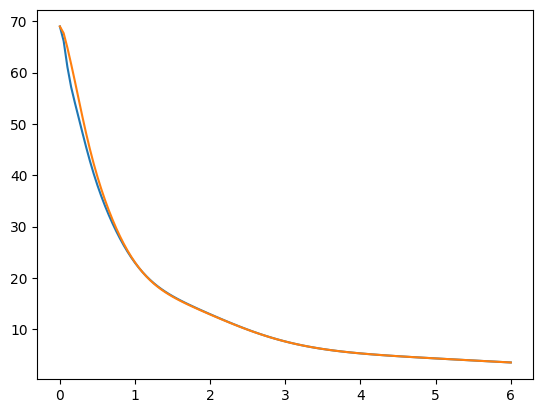

RMS difference = 0.914393,  max |Δ| = 4.484700
⚠️ Замечено отклонение — проверь заселённости или нормировку.


In [51]:
res=check_sum_shells(atom_info=Tm_info)

In [70]:
import plotly.graph_objects as go
import numpy as np

def plot_sum_shells(atom_info, y_sum_shells, title=None):
    """
    График кривых атома с Plotly.
    Показывает:
      - core
      - каждую валентную оболочку * P
      - суммарную кривую (core + valence*P)
      - кривую нейтрального атома
    """
    curves = atom_info['curves']
    x = np.array(curves['core']['x'], dtype=float)
    y_neutral = np.array(curves['neutral atom']['y'], dtype=float)

    fig = go.Figure()

    # --- core ---
    fig.add_trace(go.Scatter(x=x, y=curves['core']['y'], mode='lines', name='core',
                             line=dict(color='black', width=2)))

    # --- valence shells ---
    valence_names = [k for k in curves.keys() if k not in ['core', 'neutral atom']]
    for shell in valence_names:
        P_list = [float(v["P"]) for k,v in atom_info['valence'].items() if shell in k]
        P = sum(P_list)
        fig.add_trace(go.Scatter(x=x, y=P*np.array(curves[shell]['y'], dtype=float),
                      mode='lines', name=f'Valence: {shell} (P={P:.1f})',
                      line=dict(width=1.5, dash='dot', color='gray')))

    # --- sum (core + valence*P) ---
    fig.add_trace(go.Scatter(x=x, y=y_sum_shells, mode='lines',
                  name=r'$f_{\mathrm{sum}} = f_{\mathrm{core}} + \sum_i P_i \cdot f_i$',
                  line=dict(color='blue', width=2)))

    # --- neutral atom ---
    fig.add_trace(go.Scatter(x=x, y=y_neutral,mode='lines', name='neutral atom',
                             line=dict(color='red', width=2, dash='dash')))

    # --- layout ---
    fig.update_layout(
        title=title or f"{atom_info.get('name','Atom')}: Shell sum check",
        xaxis_title="sin(θ)/λ,  Å<sup>-1</sup>",        xaxis_title_font_family='Times New Roman',
        yaxis_title="Form-factor",              yaxis_title_font_family='Times New Roman',
        template='simple_white',
        font=dict(family='Times New Roman', size=12),
        legend=dict(font=dict(size=12), yanchor="top", y=0.99, xanchor="left", x=0.6))

    fig.show()


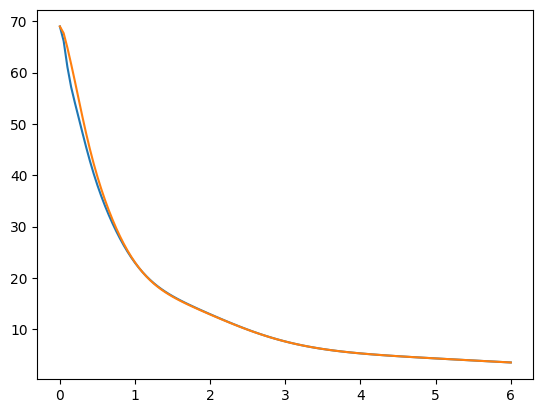

RMS difference = 0.914393,  max |Δ| = 4.484700
⚠️ Замечено отклонение — проверь заселённости или нормировку.


In [72]:
Tm_info = read_scatfile('Tm.txt')
ok, rms, max_diff, y_sum_shells = check_sum_shells(atom_info=Tm_info)
plot_sum_shells(Tm_info, y_sum_shells, title=f'Atom "Tm":<br>      RMS = {rms:.3f},    |Δ<sub>max</sub>| ={max_diff:.3f}')
